In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import random

from spacy.lang.nl import Dutch
from spacy.lemmatizer import Lemmatizer
from pathlib import Path
#from stop_words import get_stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_union
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

#frog
from time import time # To time our operation
from collections import defaultdict # For word frequency
from gensim.models.phrases import Phrases, Phraser
from pynlpl.clients.frogclient import FrogClient
import re # For preprocessing
import pandas as pd # For data handling
import pickle
import spacy # For preprocessing
import logging # For gensim logging

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff

In [2]:
nlp = Dutch()
nlp.add_pipe(nlp.create_pipe('sentencizer'))

## Read in data

In [3]:
#trainingfile = pd.read_excel('Annotation_sample_OB_ingevuld_Oele.xlsm', engine='openpyxl')


trainingfile = pd.read_csv('DatasetSA_classification.csv', sep=';')
trainingfile = trainingfile.dropna(subset=['SA Label'])
trainingfile = trainingfile[['FileName', 'FileCaption', 'Text', 'len_text', 'cleaned_text', 'SA Label' ]]
print(trainingfile.shape)
trainingfile.iloc[0]

(2119, 6)


FileName                                               NCV113.xml
FileCaption     NCV113 Meded pandrecht en inning verpande vord...
Text            Betreft: Mededeling pandrecht en inning verpan...
len_text                                                     1724
cleaned_text    Mededeling pandrecht en inning verpande vorder...
SA Label                                   informative/persuasive
Name: 0, dtype: object

## Preprocessing

In [4]:
sw_corpus = spacy.lang.nl.stop_words.STOP_WORDS
#remove SAV from the stop word list
sw_corpus.remove("geven")
sw_corpus.remove("worden")
sw_corpus.remove('kunnen')
sw_corpus.remove('zouden')
sw_corpus.remove('mogen')
sw_corpus.remove("moeten")
sw_corpus.remove("zullen")

## Lemmatization 

In [5]:
# Frog Client settings
port = 8020
frogclient = FrogClient ('localhost4', port)

In [6]:
def cleaning(doc, sw_corpus):
    #print(doc)
    if not doc: # skip empty docs
        return ""

    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object

    #print('doc:', doc)
    frog_data = frogclient.process(str(doc))
    txt = list()

    for word, lemma, morph, pos in frog_data:
        if not lemma in sw_corpus:
            #print('word: {}, lemma: {}, morph: {}, pos: {}'.format(word, lemma, morph, pos))
            #txt.append(lemma)
            if 'N(' in str(pos):
                txt.append(str(word + "(N)")) # to prevent NOUNS from being interpreted as VERBS later on
            else:
                txt.append(str(lemma))
    if 'None' in txt:
        txt.remove('None')
    #print(txt)      
    # Remove words with length 1
    txt = [word for word in txt if len(word)]
    lt_list = []

    return txt
    

In [7]:
cleaning("Uw verzoek kan niet worden ingewilligd.", sw_corpus)

['verzoek(N)', 'kunnen', 'worden', 'inwilligen', '.']

In [8]:
lemmatized_list = []

for text in trainingfile["cleaned_text"]:
    lemmatized_list.append(cleaning(text, sw_corpus))
    
trainingfile["lemmatized_text"] = lemmatized_list

## Read in speech act verbs, process as df

In [9]:
df_SAV = pd.read_excel('Speech act verbs EN-NL_def_exc.xlsx', engine='openpyxl')
df_SAV.columns = ['SAV_EN', 'SAV_NL', 'SA_label']
df_SAV = df_SAV.drop_duplicates(subset=['SAV_NL'], keep="first")
print(df_SAV.shape)
#df_SAV.to_csv( 'testje.csv')
df_SAV = df_SAV.drop(columns='SAV_EN')
dict_SAV = df_SAV.set_index('SAV_NL').T.to_dict(orient = 'r')
df_SAV.tail()

#dict_SAV

(212, 3)


/home/ADS/rinkl00_w00215/stageLR/lib64/python3.6/site-packages/pandas/core/frame.py:1490: FutureWarning:

Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.



,SAV_NL,SA_label
251,motiveren,directive/instructive
253,moeten,directive/instructive
254,dienen,directive/instructive
255,zullen,commissive
256,kunnen,commissive


In [10]:
final_dict_SAV = dict()
for dict_new in dict_SAV:
    final_dict_SAV = dict_new
    

In [11]:
final_dict_SAV["verlenen"]

'declarative'

In [12]:
#list(sw_corpus).intersect(list(final_dict_SAV.keys()))

def intersection(l1, l2):
    l3 = [value for value in l1 if value in l2]
    return l3

intersection(list(sw_corpus), list(final_dict_SAV.keys())) ##check if no SAV are removed by the stop word list

[]

In [13]:
def find_SAV_label(lt_sentence, SAV_dict):
    SAV_label_list = []
    SAV_label_dict = dict()
    SAV_label_dict["declarative"] = 0
    SAV_label_dict["commissive"] = 0
    SAV_label_dict["directive/instructive"] = 0
    SAV_label_dict["informative/persuasive"] = 0
    SAV_label_dict["miscellaneous"] = 0
    #print(lt_sentence)
    
    for token in lt_sentence:
        #print(token)
        if token in SAV_dict.keys():
            #print(token)
            if "N(" not in token: 
                #print(token)
                #print("-------------------------------------")
                #print( )
                if SAV_dict[token] == 'informative/persuasive':
                    SAV_label_dict['informative/persuasive'] += 1
                if SAV_dict[token] == 'directive/instructive':
                    SAV_label_dict['directive/instructive'] += 1
                if SAV_dict[token] == 'commissive':
                    SAV_label_dict['commissive'] += 1
                if SAV_dict[token] == 'declarative':
                    SAV_label_dict['declarative'] += 1
                if SAV_dict[token] == 'miscellaneous':
                    SAV_label_dict['miscellaneous'] += 1
    SAV_label_list.append(SAV_label_dict)
    return SAV_label_dict, SAV_label_list
    
    

## Make judgements based on inserted data and dict

In [14]:
sentence = cleaning('Om gebruik te maken van de regeling moet u eerst de voorwaarden accepteren.', sw_corpus)
print(find_SAV_label(sentence, final_dict_SAV)[1])

[{'declarative': 0, 'commissive': 0, 'directive/instructive': 1, 'informative/persuasive': 1, 'miscellaneous': 0}]


In [15]:
label_dict_list = []
for sent in lemmatized_list:
    label_dict_list.append(find_SAV_label(sent, final_dict_SAV)[0])
    
trainingfile["label_dict"] = label_dict_list

In [16]:
def make_judgement(label_dict_list):
    final_label_list = []
    counter = 0
    for label_dict in label_dict_list:
        counter += 1
        #print(label_dict)
        
        if label_dict['informative/persuasive'] != 0:
            #print(label_dict)
            if label_dict['informative/persuasive'] == label_dict['directive/instructive']:
                max_class = 'informative/persuasive'
            if label_dict['informative/persuasive'] == label_dict['commissive']:
                max_class = 'informative/persuasive'
            if label_dict['informative/persuasive'] == label_dict['declarative']:
                max_class = 'informative/persuasive'
            else:
                max_class = max(label_dict, key=label_dict.get)
        
        if max(label_dict.values()) == 0:
            max_class = 'miscellaneous'
            #print("yes")
                
        #if 
        else:
            max_class = max(label_dict, key=label_dict.get)
        #print(max_class)
        #print()
        final_label_list.append(max_class)
    return final_label_list
        

In [17]:
trainingfile["rule_based_label"] = make_judgement(label_dict_list) ##use label dict list to make a final judgement

In [18]:
Counter(trainingfile["SA Label"]) ##distribution of the true labels

Counter({'informative/persuasive': 1125,
         'directive/instructive': 487,
         'miscellaneous': 158,
         'commissive': 171,
         'declarative': 178})

In [19]:
Counter(trainingfile["rule_based_label"]) ##distribution of the predicted labels

Counter({'miscellaneous': 1148,
         'directive/instructive': 344,
         'declarative': 193,
         'informative/persuasive': 161,
         'commissive': 273})

In [20]:
print(classification_report(trainingfile["SA Label"].tolist(), trainingfile["rule_based_label"].tolist()))

                        precision    recall  f1-score   support

            commissive       0.22      0.35      0.27       171
           declarative       0.08      0.08      0.08       178
 directive/instructive       0.42      0.30      0.35       487
informative/persuasive       0.47      0.07      0.12      1125
         miscellaneous       0.12      0.86      0.21       158

              accuracy                           0.20      2119
             macro avg       0.26      0.33      0.20      2119
          weighted avg       0.38      0.20      0.19      2119



[[ 76  21  11  48   5]
 [159 144  19  14   8]
 [ 97 106  60   9   1]
 [ 83  77  10  15   8]
 [710 139  71  92 136]]


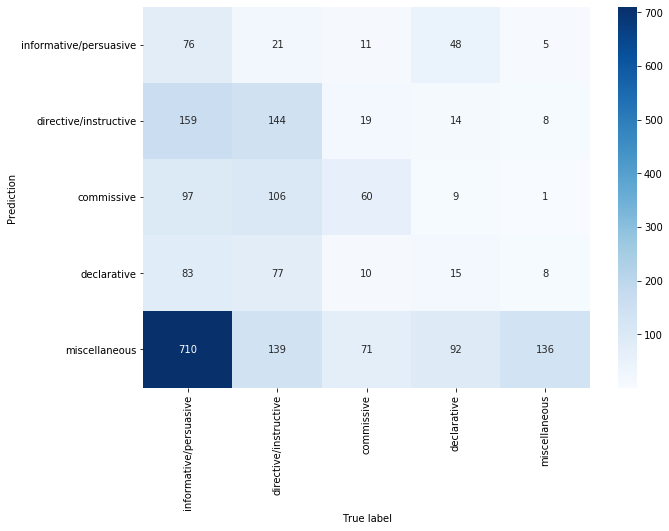

In [21]:
labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

cm = confusion_matrix(trainingfile["rule_based_label"].tolist(), trainingfile["SA Label"].tolist(), normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot


## Generate SAV features for ensemble model and write to CSV

In [22]:
SAV_dict_df = pd.DataFrame(label_dict_list)
SAV_dict_df.to_csv("SAV_features.csv", sep=';')

## Performance on development & test set (for comparison)

### Development

In [23]:
trainingfile = pd.read_csv('DatasetSA_classification.csv', sep=';')

trainingfile = trainingfile[['FileName', 'FileCaption', 'Text', 'len_text', 'cleaned_text', 'SA Label' ]]
trainingfile = trainingfile.dropna(subset=['SA Label'])
trainingfile = trainingfile.drop_duplicates(subset= 'cleaned_text')

X = trainingfile[['cleaned_text']]
y = trainingfile['SA Label']

X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.2, random_state=42, stratify=trainingfile['SA Label'])

X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size= 0.5, random_state=42, stratify=y_valtest)




In [24]:
lemmatized_list_val = []

for text in X_val["cleaned_text"]:
    lemmatized_list_val.append(cleaning(text, sw_corpus))
    
X_val["lemmatized_text"] = lemmatized_list_val

In [25]:
label_dict_list_val = []
for sent in lemmatized_list_val:
    label_dict_list_val.append(find_SAV_label(sent, final_dict_SAV)[0])
    
X_val["label_dict"] = label_dict_list_val

In [26]:
X_val["rule_based_label"] = make_judgement(label_dict_list_val)

[[ 4  1  1  4  0]
 [15 18  3  2  0]
 [10 13  5  0  0]
 [12  5  0  1  3]
 [72 11  8 11 13]]


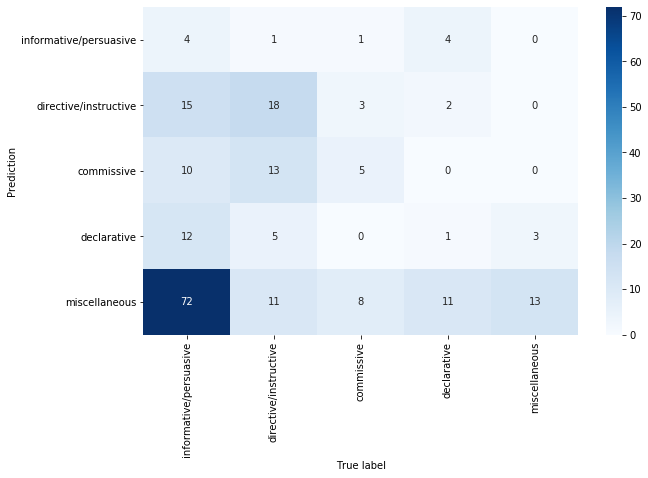

In [27]:
labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

cm = confusion_matrix(X_val["rule_based_label"].tolist(), y_val.tolist(), normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plt.tight_layout(pad=2)
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/RBS_val.png')

In [28]:
print(classification_report(X_val["rule_based_label"].tolist(), y_val.tolist()))

                        precision    recall  f1-score   support

            commissive       0.29      0.18      0.22        28
           declarative       0.06      0.05      0.05        21
 directive/instructive       0.38      0.47      0.42        38
informative/persuasive       0.04      0.40      0.07        10
         miscellaneous       0.81      0.11      0.20       115

              accuracy                           0.19       212
             macro avg       0.31      0.24      0.19       212
          weighted avg       0.55      0.19      0.22       212



### test

In [29]:
lemmatized_list_test = []

for text in X_test["cleaned_text"]:
    lemmatized_list_test.append(cleaning(text, sw_corpus))
    
X_test["lemmatized_text"] = lemmatized_list_test

In [30]:
label_dict_list_test = []
for sent in lemmatized_list_test:
    label_dict_list_test.append(find_SAV_label(sent, final_dict_SAV)[0])
    
X_test["label_dict"] = label_dict_list_test

In [31]:
X_test["rule_based_label"] = make_judgement(label_dict_list_test)

[[10  4  1  7  0]
 [15 11  2  1  1]
 [10 12  6  1  0]
 [ 9  7  3  1  0]
 [68 15  5  8 15]]


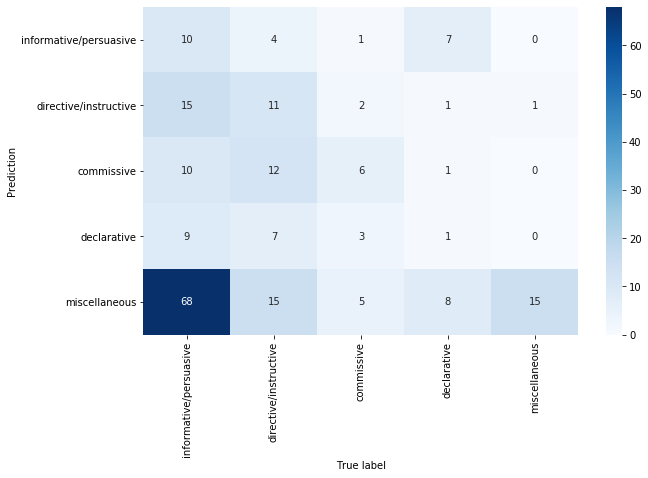

In [32]:
labels=['informative/persuasive','directive/instructive', 'commissive', 'declarative', 'miscellaneous']
x = labels
y = labels

cm = confusion_matrix(X_test["rule_based_label"].tolist(), y_test.tolist(), normalize=None, labels=labels)

print(cm)
#fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='Viridis')
#fig.show("notebook")

plt.figure(figsize = (10,7))
plot = sns.heatmap(cm, annot=True, xticklabels=x, yticklabels=y, cmap='Blues', fmt='d')
plot.set_xlabel("True label")
plot.set_ylabel("Prediction")
plot
plt.tight_layout(pad=2)
plot.figure.savefig('pics/RBS_test.png')

In [33]:
print(classification_report(X_test["rule_based_label"].tolist(), y_test.tolist()))

                        precision    recall  f1-score   support

            commissive       0.35      0.21      0.26        29
           declarative       0.06      0.05      0.05        20
 directive/instructive       0.22      0.37      0.28        30
informative/persuasive       0.09      0.45      0.15        22
         miscellaneous       0.94      0.14      0.24       111

              accuracy                           0.20       212
             macro avg       0.33      0.24      0.20       212
          weighted avg       0.59      0.20      0.22       212



In [34]:
Counter(X_val['rule_based_label'])

Counter({'miscellaneous': 115,
         'directive/instructive': 38,
         'commissive': 28,
         'informative/persuasive': 10,
         'declarative': 21})

In [35]:
Counter(y_test)

Counter({'directive/instructive': 49,
         'informative/persuasive': 112,
         'miscellaneous': 16,
         'commissive': 17,
         'declarative': 18})

## Error analysis

In [36]:
error_analysis = X_test

In [37]:
error_analysis.shape

(212, 4)

In [38]:
error_analysis["gold label"] = y_test

In [85]:
counter = 0
error_counter = 0
values_list = []
values_counter = 0
zero_dict_counter = 0
for row in error_analysis.values:
    counter += 1
    if row[-1] != row[-2]:
        values_list = []
        values_counter = 0
        error_counter += 1
        #if row[-2] == 'directive/instructive':
        #if 'sturen' in row[1]:
                #error_counter += 1
                #print(row)
                #print()
                #zero_dict_counter += 1
                #continue
        #print("Sentence: ", row[0][:50])
        #print("decision dict: ", row[2])
    for key, value in row[2].items():
        if value >= 1:
            values_list.append(key)
            values_counter += 1
    #if row[-1] == row[-2]:
    #if 'moeten' in row[1]:
        #zero_dict_counter += 1
   # if values_counter >= 2:
        #print(row)
        #print()
        #zero_dict_counter += 1
        
       # if row[2] == {'declarative': 0, 'commissive': 0, 'directive/instructive': 0, 'informative/persuasive': 0, 'miscellaneous': 0}:
           # zero_dict_counter += 1 
           # print(row)
           # print()
        
        
        #print("gold label: ", row[-1], '-- predicted label: ', row[-2])
            
        
print("FINAL COUNTS")        
print("counter: ", counter)
print("errors: ", error_counter)
print("ties: ", values_counter)
print("zero dicts: ", zero_dict_counter)

FINAL COUNTS
counter:  212
errors:  169
ties:  0
zero dicts:  0


In [ ]:
Counter(final_dict_SAV.values())

In [ ]:
len(final_dict_SAV.values())